# NBA Game Prediction (3)

## Introduction
In this script, we are performing data preprocessing and feature engineering for our NBA game prediction project. We start by loading the structured data created in the previous step, and then we transform and create new features that might be useful for predicting the outcome of NBA games. We also select the most important features using Sequential Feature Selection. Lastly, we evaluate our choices by backtesting a simple Ridge Regression model.

## Step 1: Data Loading
First, let's load the dataset and take a look at the structure. We'll be using pandas, a Python library, for this. Let's load the data and print the first few rows.


In [1]:
import pandas as pd

df = pd.read_csv("nba_games.csv", index_col=0)

In [2]:
df.head()

,mp,mp.1,fg,fga,fg%,3p,3pa,3p%,ft,fta,...,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won
0,240.0,240.0,39.0,81.0,0.481,6.0,20.0,0.300,14.0,18.0,...,22.8,29.0,178.0,111.0,DAL,95,1,2016,2015-12-09,True
1,240.0,240.0,36.0,100.0,0.360,7.0,31.0,0.226,16.0,19.0,...,50.0,32.6,152.0,111.0,ATL,98,0,2016,2015-12-09,False
2,240.0,240.0,37.0,85.0,0.435,8.0,19.0,0.421,17.0,23.0,...,20.0,30.9,148.0,116.0,SAS,107,1,2018,2017-10-18,False
3,240.0,240.0,41.0,89.0,0.461,8.0,21.0,0.381,17.0,19.0,...,28.6,30.9,138.0,118.0,MIN,99,0,2018,2017-10-18,True
4,240.0,240.0,27.0,86.0,0.314,6.0,26.0,0.231,15.0,20.0,...,16.8,30.9,157.0,90.0,MEM,92,1,2021,2021-04-30,False



The dataset contains numerous variables, such as:

- mp: Minutes played
- mp.1: Minutes played by the opponent team
- fg: Field goals
- fga: Field goal attempts
- fg%: Field goal percentage
- 3p: 3-point field goals
- 3pa: 3-point field goal attempts
- 3p%: 3-point field goal percentage
- ft: Free throws
- fta: Free throw attempts
- ft%: Free throw percentage
- orb: Offensive rebounds
- drb: Defensive rebounds
- trb: Total rebounds
- ast: Assists
- stl: Steals
- blk: Blocks
- tov: Turnovers
- pf: Personal fouls
- pts: Points
- won: Whether the team won or lost

Among others. The _opp suffix indicates stats for the opponent team.
    

## Step 2: Data Cleaning

Before we proceed with the exploratory data analysis, it's important to clean the data. We'll check for missing values, inconsistencies, and errors. Let's start by checking for missing values.

In [3]:
# Check for missing values
df.isnull().sum()

mp           0
mp.1         0
fg           0
fga          0
fg%          0
            ..
total_opp    0
home_opp     0
season       0
date         0
won          0
Length: 150, dtype: int64

In [4]:
# sort the DataFrame df by the "date" column in ascending order.
df = df.sort_values("date")

In [5]:
# reset the index of the DataFrame. The drop=True argument means that the old index is discarded.
df = df.reset_index(drop=True)

In [6]:
# delete the specified columns from the DataFrame
del df["mp.1"]
del df["mp_opp.1"]
del df["index_opp"]

In [7]:
# This function adds a new column "target" to a DataFrame group by shifting the "won" column down by one. This means that the "target" column will contain the value of the "won" column from the next row.
def add_target(group):
    group["target"] = group["won"].shift(-1)
    return group


In [8]:
# groups the DataFrame by the "team" column and then applies the add_target function to each group. This results in a new "target" column being added to the DataFrame.
df = df.groupby("team", group_keys=False).apply(add_target)

In [9]:
# selects rows from the DataFrame where the "team" column is equal to "GSW".
df[df["team"] == "GSW"]

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,...,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,target
3,240.0,41.0,96.0,0.427,9.0,30.0,0.300,20.0,22.0,0.909,...,38.9,201.0,120.0,NOP,95,0,2016,2015-10-27,True,True
44,240.0,43.0,93.0,0.462,9.0,26.0,0.346,17.0,25.0,0.680,...,37.5,151.0,118.0,HOU,92,1,2016,2015-10-30,True,True
67,240.0,46.0,84.0,0.548,17.0,30.0,0.567,25.0,35.0,0.714,...,36.1,218.0,131.0,NOP,120,1,2016,2015-10-31,True,True
98,240.0,43.0,84.0,0.512,11.0,25.0,0.440,22.0,30.0,0.733,...,44.3,106.0,126.0,MEM,69,0,2016,2015-11-02,True,True
137,240.0,39.0,85.0,0.459,10.0,26.0,0.385,24.0,31.0,0.774,...,32.9,250.0,122.0,LAC,108,0,2016,2015-11-04,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17762,240.0,39.0,86.0,0.453,15.0,37.0,0.405,14.0,20.0,0.700,...,35.2,300.0,117.0,BOS,88,0,2022,2022-06-05,True,False
17764,240.0,36.0,78.0,0.462,15.0,40.0,0.375,13.0,15.0,0.867,...,28.8,175.0,117.0,BOS,116,1,2022,2022-06-08,False,True
17766,240.0,40.0,91.0,0.440,15.0,43.0,0.349,12.0,15.0,0.800,...,32.4,205.0,120.0,BOS,97,1,2022,2022-06-10,True,True
17768,240.0,41.0,88.0,0.466,9.0,40.0,0.225,13.0,15.0,0.867,...,94.4,300.0,112.0,BOS,94,0,2022,2022-06-13,True,True


In [10]:
# fills missing values in the "target" column with the value 2
df["target"][pd.isnull(df["target"])] = 2

/var/folders/w5/ln6jl9bd0zd09jkkpx_9_zlc0000gn/T/ipykernel_47118/728186745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"][pd.isnull(df["target"])] = 2


In [11]:
# converts the "target" column to integer type
df["target"] = df["target"].astype(int, errors="ignore")

In [12]:
# counts the number of each unique value in the "won" column.
df["won"].value_counts()

False    8886
True     8886
Name: won, dtype: int64

In [13]:
# counts the number of each unique value in the "target" column
df["target"].value_counts()

1    8872
0    8870
2      30
Name: target, dtype: int64

In [14]:
# calculates the total number of missing values in each column of the DataFrame.
nulls = pd.isnull(df).sum()

In [15]:
# filters out columns where the total number of missing values is greater than 0
nulls = nulls[nulls > 0]

In [16]:
# creates a list of column names that do not contain missing values
valid_columns = df.columns[~df.columns.isin(nulls.index)]

In [17]:
valid_columns

Index(['mp', 'fg', 'fga', 'fg%', '3p', '3pa', '3p%', 'ft', 'fta', 'ft%',
       ...
       'usg%_max_opp', 'ortg_max_opp', 'drtg_max_opp', 'team_opp', 'total_opp',
       'home_opp', 'season', 'date', 'won', 'target'],
      dtype='object', length=142)

In [18]:
# creates a new DataFrame that only includes the columns without missing values
df = df[valid_columns].copy()


In [19]:
df

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,...,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,target
0,240.0,35.0,83.0,0.422,6.0,18.0,0.333,19.0,27.0,0.704,...,43.7,206.0,104.0,GSW,111,1,2016,2015-10-27,False,0
1,240.0,38.0,94.0,0.404,9.0,29.0,0.310,10.0,17.0,0.588,...,34.6,162.0,104.0,CHI,97,1,2016,2015-10-27,False,1
2,240.0,37.0,87.0,0.425,7.0,19.0,0.368,16.0,23.0,0.696,...,29.0,138.0,105.0,CLE,95,0,2016,2015-10-27,True,1
3,240.0,41.0,96.0,0.427,9.0,30.0,0.300,20.0,22.0,0.909,...,38.9,201.0,120.0,NOP,95,0,2016,2015-10-27,True,1
4,240.0,37.0,82.0,0.451,8.0,27.0,0.296,12.0,15.0,0.800,...,23.6,132.0,104.0,DET,106,0,2016,2015-10-27,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17767,240.0,34.0,85.0,0.400,15.0,38.0,0.395,14.0,19.0,0.737,...,36.3,133.0,112.0,GSW,107,0,2022,2022-06-10,False,0
17768,240.0,41.0,88.0,0.466,9.0,40.0,0.225,13.0,15.0,0.867,...,94.4,300.0,112.0,BOS,94,0,2022,2022-06-13,True,1
17769,240.0,31.0,75.0,0.413,11.0,32.0,0.344,21.0,31.0,0.677,...,36.2,222.0,107.0,GSW,104,1,2022,2022-06-13,False,0
17770,240.0,34.0,80.0,0.425,11.0,28.0,0.393,11.0,12.0,0.917,...,31.5,186.0,111.0,GSW,103,0,2022,2022-06-16,False,2


## Step 3: Exploratory Data Analysis (EDA)

Exploratory Data Analysis is a key step in understanding the data we're working with. By visualizing our data, we can gain insights that may be helpful in our later analysis and modeling.

Let's start by visualizing the distribution of wins and losses in our dataset. We will use seaborn library for this.

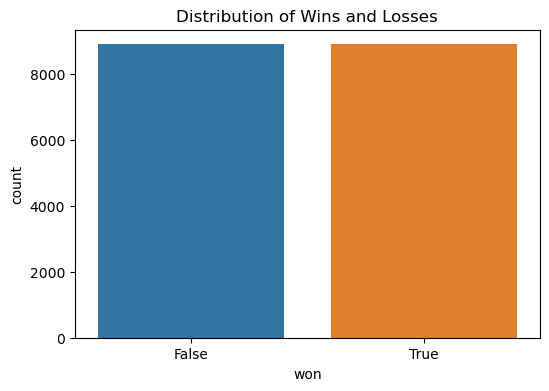

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot for the target variable
plt.figure(figsize=(6,4))
sns.countplot(x='won', data=df)
plt.title('Distribution of Wins and Losses')
plt.show()

The distribution of wins and losses seems to be relatively balanced, which is good for our modeling later on.

Now, let's explore the correlation between different features and the target variable won. We'll choose a subset of variables for simplicity. We will use a heatmap for this purpose.

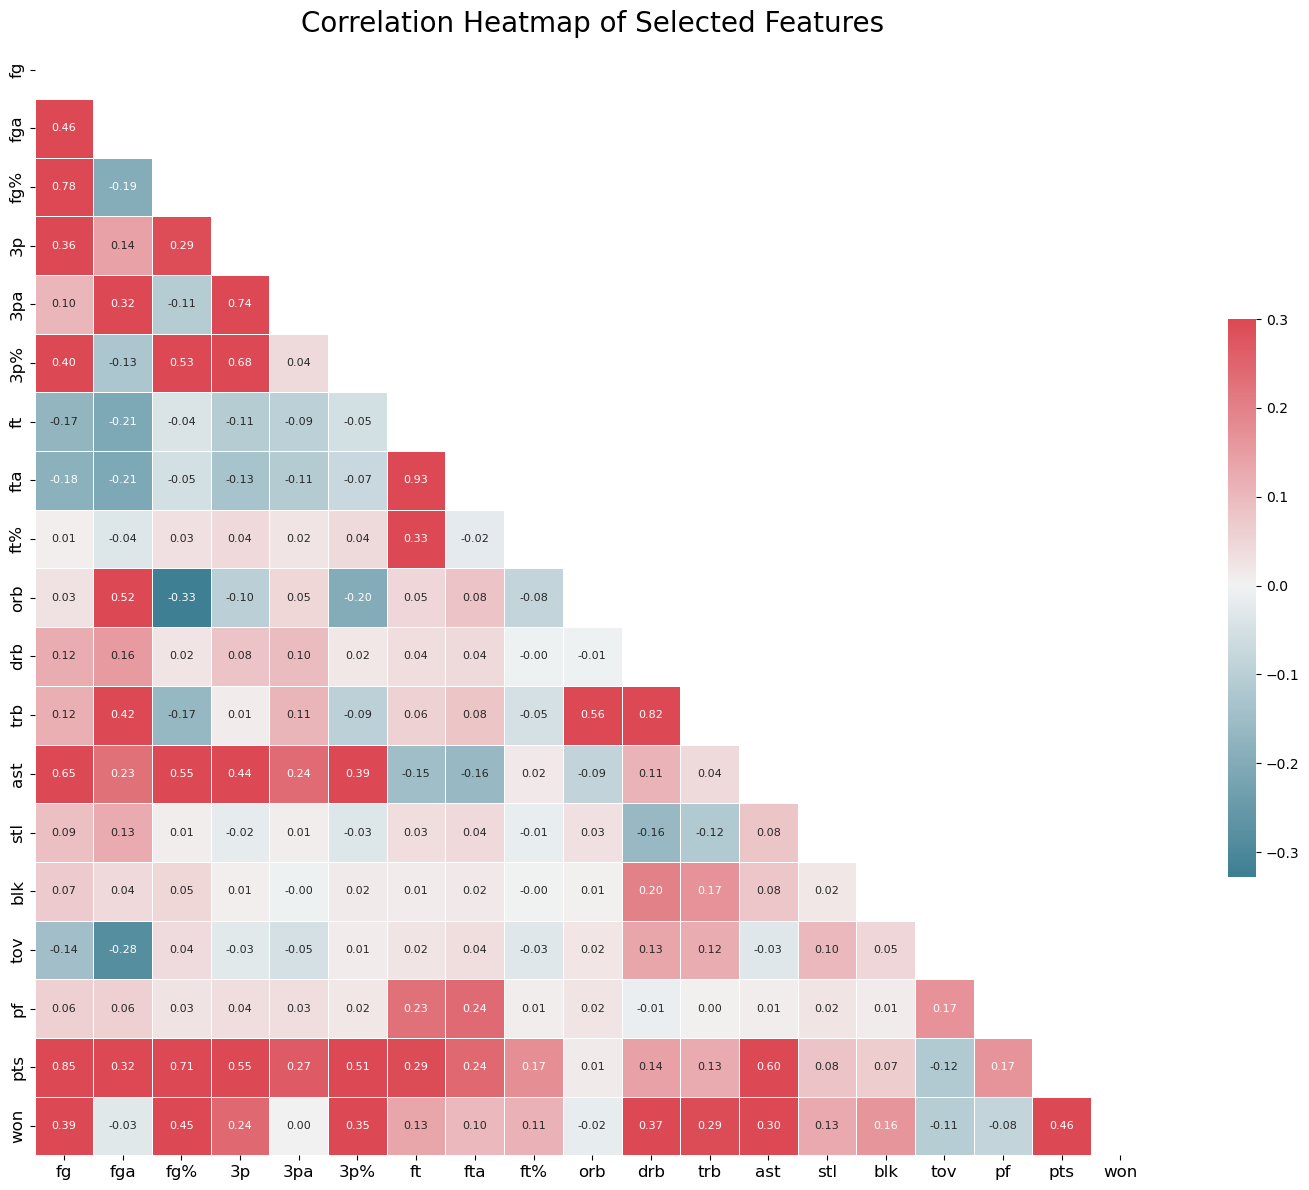

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Subset of features
features = ['fg', 'fga', 'fg%', '3p', '3pa', '3p%', 'ft', 'fta', 'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'won']

# Compute the correlation matrix
corr = df[features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f", annot_kws={"size": 8})

# Improve aesthetics
plt.title('Correlation Heatmap of Selected Features', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


The heatmap gives us a visual representation of the correlation between different features. The correlation ranges from -1 to 1. A correlation close to 1 indicates a strong positive correlation, while a correlation close to -1 indicates a strong negative correlation. A correlation close to 0 indicates no correlation.

From the heatmap, it seems that pts (points scored) has the strongest positive correlation with the won target variable. This makes intuitive sense, as scoring more points in a game generally leads to a win. Other factors such as fg (field goals) and ft (free throws) also show a strong correlation.

### Team-wise win and loss counts.
To do this, we first need to create a count of wins and losses for each team. Let's do this now.

In [22]:
# Count wins and losses for each team
team_wins_losses = df.groupby(['team', 'won']).size().unstack(fill_value=0)

# Display the first few rows of the count data
team_wins_losses.head()


won,False,True
team,,
ATL,323,267
BOS,260,393
BRK,333,247
CHI,324,234
CHO,295,261


Here we have the count of wins (True) and losses (False) for each team. Now, let's visualize this data as a stacked bar plot. This will allow us to easily compare the number of wins and losses for each team.

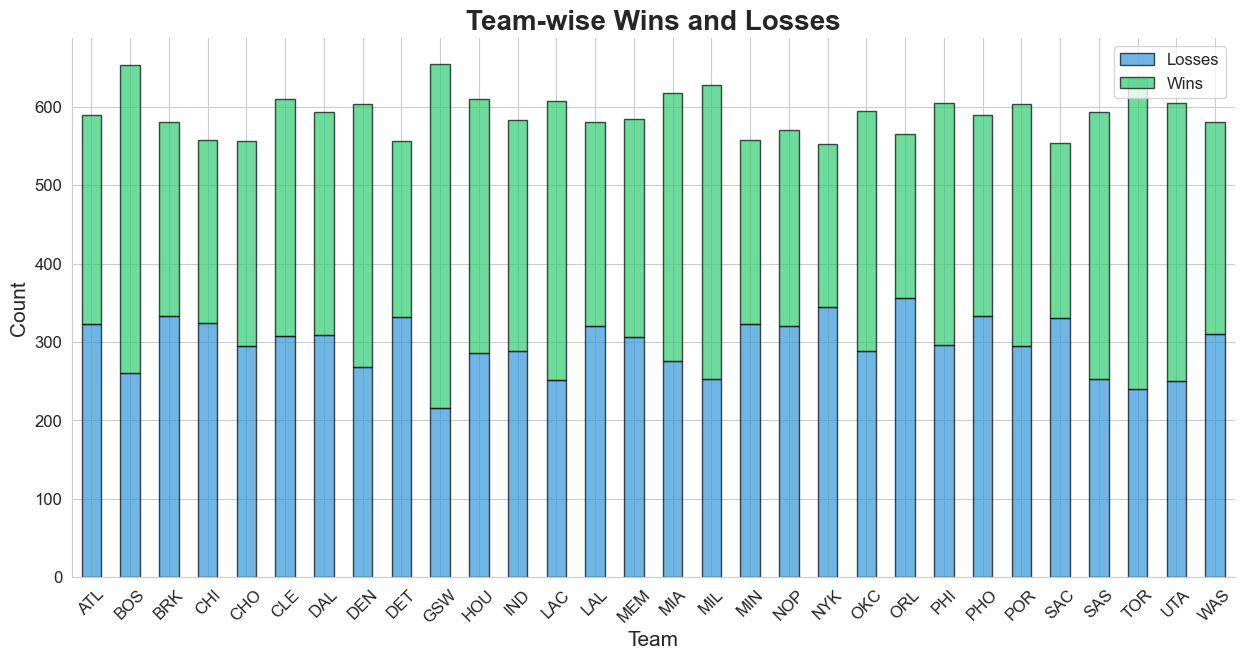

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and color palette
sns.set_style("whitegrid")
color_palette = ["#3498db", "#2ecc71"]

# Create a stacked bar plot
team_wins_losses.plot(kind='bar', stacked=True, figsize=(15, 7), color=color_palette, alpha=0.7, edgecolor='black')

# Customize the plot
plt.title('Team-wise Wins and Losses', fontsize=20, fontweight='bold')
plt.xlabel('Team', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(['Losses', 'Wins'], loc='upper right', fontsize=12)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Remove top and right borders
sns.despine()

# Show the plot
plt.show()


The stacked bar plot gives us a clear visualization of the number of wins and losses for each team. Teams are represented along the x-axis, and the count of games is represented along the y-axis. Losses are shown in blue, and wins are shown in green.

### Distribution of points (pts):
Let's visualize the distribution of points scored by teams using a histogram. This can help us understand the range and frequency of points usually scored in a game.

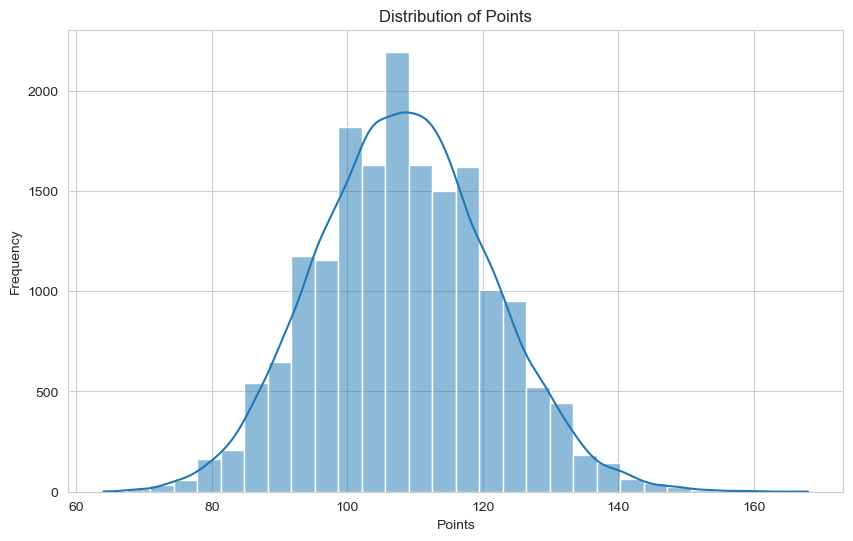

In [24]:
# Create a histogram for the 'pts' feature
plt.figure(figsize=(10, 6))
sns.histplot(df['pts'], bins=30, kde=True)
plt.title('Distribution of Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

The histogram shows the distribution of points scored in games. It appears that the most common range of points scored in a game is around 100 to 110.

### Boxplots for various statistics:
Let's create boxplots for various statistics like fg (field goals), ast (assists), and blk (blocks). Boxplots can show us the distribution of these statistics and help identify any outliers.

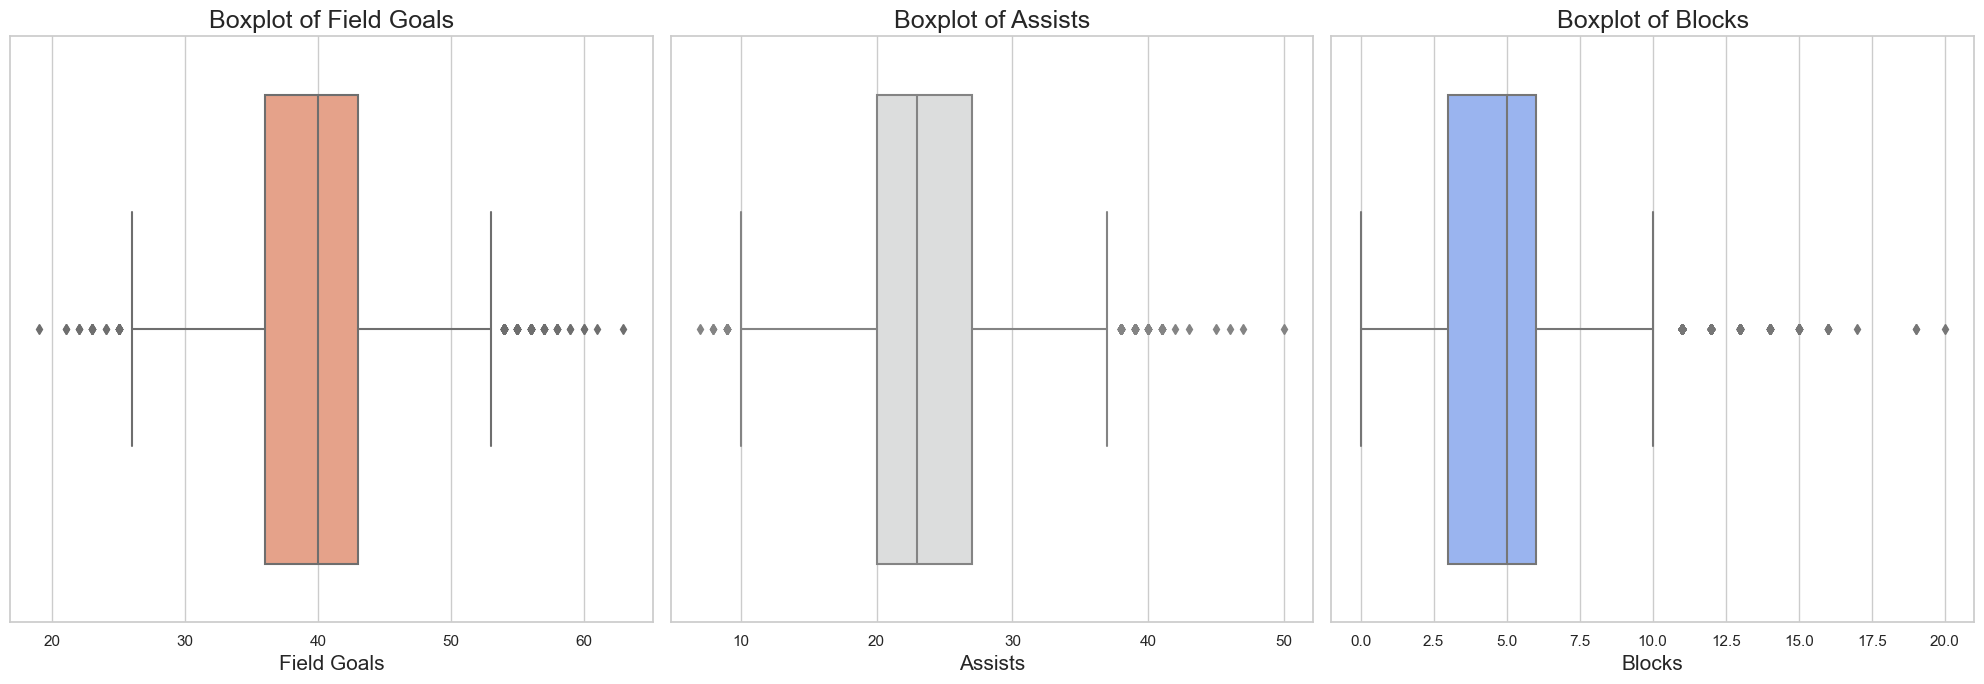

In [25]:
# Set seaborn style
sns.set(style="whitegrid")

# Create figure and specify figure size
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Create a color palette
palette = sns.color_palette("coolwarm_r", 3)

# Field goals
sns.boxplot(x=df['fg'], ax=axes[0], color=palette[0])
axes[0].set_title('Boxplot of Field Goals', fontsize=18)
axes[0].set_xlabel('Field Goals', fontsize=15)

# Assists
sns.boxplot(x=df['ast'], ax=axes[1], color=palette[1])
axes[1].set_title('Boxplot of Assists', fontsize=18)
axes[1].set_xlabel('Assists', fontsize=15)

# Blocks
sns.boxplot(x=df['blk'], ax=axes[2], color=palette[2])
axes[2].set_title('Boxplot of Blocks', fontsize=18)
axes[2].set_xlabel('Blocks', fontsize=15)

# Automatically adjust subplot params so that the subplot fits into the figure area
plt.tight_layout()

# Show the plot
plt.show()

The boxplots show the distribution of field goals, assists, and blocks. The box represents the interquartile range (IQR), the line inside the box is the median, and the whiskers represent values within 1.5 times the IQR. Points outside the whiskers are considered outliers.

## Step 4: Feature Selection

In [26]:
# Imports the required sklearn modules for feature selection, data splitting, and ridge classification
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit

In [27]:
# creates an instance of the RidgeClassifier with alpha (regularization strength) set to 1
rr = RidgeClassifier(alpha=1)

In [28]:
# creates an instance of TimeSeriesSplit with 3 splits. This will be used for cross-validation
split = TimeSeriesSplit(n_splits=3)

In [29]:
# creates an instance of SequentialFeatureSelector. It uses the RidgeClassifier instance rr, selects 30 features, uses a 'forward' direction for feature selection, uses the TimeSeriesSplit instance split for cross-validation, and sets n_jobs=1 which means the computation is not parallelized.
sfs = SequentialFeatureSelector(rr,
                                n_features_to_select=30,
                                direction="forward",
                                cv=split,
                                n_jobs=1
                               )


In [30]:
# Here we define the columns to be removed before feature selection. selected_columns are the columns that are kept for further processing, which are all columns of df excluding those listed in removed_columns.
removed_columns = ["season", "date", "won", "target", "team", "team_opp"]
selected_columns = df.columns[~df.columns.isin(removed_columns)]

In [31]:
selected_columns

Index(['mp', 'fg', 'fga', 'fg%', '3p', '3pa', '3p%', 'ft', 'fta', 'ft%',
       ...
       'trb%_max_opp', 'ast%_max_opp', 'stl%_max_opp', 'blk%_max_opp',
       'tov%_max_opp', 'usg%_max_opp', 'ortg_max_opp', 'drtg_max_opp',
       'total_opp', 'home_opp'],
      dtype='object', length=136)

In [32]:
# imports MinMaxScaler, a module that scales and translates each feature individually such that it is in the given range on the training set, i.e between zero and one. It then creates an instance of this scaler.
from sklearn.preprocessing import MinMaxScaler

In [33]:
scaler = MinMaxScaler()

#applies the scaling on the selected columns of the dataframe.
df[selected_columns] = scaler.fit_transform(df[selected_columns])

In [34]:
df

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,...,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,target
0,0.0,0.363636,0.338235,0.366029,0.206897,0.212121,0.395487,0.418605,0.412698,0.654609,...,0.277279,0.554502,0.317647,GSW,0.451923,1.0,2016,2015-10-27,False,0
1,0.0,0.431818,0.500000,0.322967,0.310345,0.378788,0.368171,0.209302,0.253968,0.519253,...,0.160462,0.345972,0.317647,CHI,0.317308,1.0,2016,2015-10-27,False,1
2,0.0,0.409091,0.397059,0.373206,0.241379,0.227273,0.437055,0.348837,0.349206,0.645274,...,0.088575,0.232227,0.329412,CLE,0.298077,0.0,2016,2015-10-27,True,1
3,0.0,0.500000,0.529412,0.377990,0.310345,0.393939,0.356295,0.441860,0.333333,0.893816,...,0.215661,0.530806,0.505882,NOP,0.298077,0.0,2016,2015-10-27,True,1
4,0.0,0.409091,0.323529,0.435407,0.275862,0.348485,0.351544,0.255814,0.222222,0.766628,...,0.019255,0.203791,0.317647,DET,0.403846,0.0,2016,2015-10-27,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17767,0.0,0.340909,0.367647,0.313397,0.517241,0.515152,0.469121,0.302326,0.285714,0.693116,...,0.182285,0.208531,0.411765,GSW,0.413462,0.0,2022,2022-06-10,False,0
17768,0.0,0.500000,0.411765,0.471292,0.310345,0.545455,0.267221,0.279070,0.222222,0.844807,...,0.928113,1.000000,0.411765,BOS,0.288462,0.0,2022,2022-06-13,True,1
17769,0.0,0.272727,0.220588,0.344498,0.379310,0.424242,0.408551,0.465116,0.476190,0.623104,...,0.181001,0.630332,0.352941,GSW,0.384615,1.0,2022,2022-06-13,False,0
17770,0.0,0.340909,0.294118,0.373206,0.379310,0.363636,0.466746,0.232558,0.174603,0.903151,...,0.120668,0.459716,0.400000,GSW,0.375000,0.0,2022,2022-06-16,False,2


In [35]:
# This line fits the Sequential Feature Selector on the selected columns of the dataframe and the target column. This is the actual feature selection step where the algorithm decides what are the best features to use based on their contribution to the target variable.
sfs.fit(df[selected_columns], df["target"])


SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=RidgeClassifier(alpha=1),
                          n_features_to_select=30, n_jobs=1)

In [36]:
# Here, the code retrieves the names of the features selected by the Sequential Feature Selector and stores them in the predictors variable.
predictors = list(selected_columns[sfs.get_support()])


In [37]:
predictors


['mp',
 'fg%',
 '3p%',
 'orb',
 'ts%',
 'usg%',
 '3p%_max',
 'ft_max',
 'fta_max',
 '+/-_max',
 'drb%_max',
 'trb%_max',
 'tov%_max',
 'usg%_max',
 'mp_opp',
 'fg_opp',
 '3p_opp',
 'ft%_opp',
 'blk_opp',
 'usg%_opp',
 'fga_max_opp',
 '3p_max_opp',
 'ft_max_opp',
 'ft%_max_opp',
 'blk_max_opp',
 'pf_max_opp',
 'pts_max_opp',
 'drb%_max_opp',
 'blk%_max_opp',
 'usg%_max_opp']

## Step 5: Model Training
This function backtest() is a custom cross-validation scheme for time-series data. It iterates over different seasons in the data, using all previous seasons as training data and the current season as the test data. The function trains the model on the training data and makes predictions on the test data. These predictions are stored and returned in a dataframe along with the actual values.

In [38]:
def backtest(data, model, predictors, start=2, step=1):
    all_predictions = []
    seasons = sorted(data["season"].unique())
    for i in range(start, len(seasons), step):
        season = seasons[i]
        train = data[data["season"] < season]
        test = data[data["season"] == season]
        model.fit(train[predictors], train["target"])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [39]:
predictions = backtest(df, rr, predictors)

## Step 6: Model Evaluation
Here, the accuracy_score() function from sklearn.metrics is used to calculate the accuracy of the model predictions. The accuracy is the proportion of correct predictions made out of total predictions.

In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(predictions["actual"], predictions["prediction"])

0.5471969333972209

In [41]:
# This is calculating the win rate for home games. It groups the data by the 'home' field, then for each group it finds the proportion of games where 'won' is 1.
df.groupby(["home"]).apply(lambda x: x[x["won"] == 1].shape[0] / x.shape[0])

home
0.0    0.428314
1.0    0.571686
dtype: float64

## Step 7: Feature Engineering


In [42]:
df

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,...,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,target
0,0.0,0.363636,0.338235,0.366029,0.206897,0.212121,0.395487,0.418605,0.412698,0.654609,...,0.277279,0.554502,0.317647,GSW,0.451923,1.0,2016,2015-10-27,False,0
1,0.0,0.431818,0.500000,0.322967,0.310345,0.378788,0.368171,0.209302,0.253968,0.519253,...,0.160462,0.345972,0.317647,CHI,0.317308,1.0,2016,2015-10-27,False,1
2,0.0,0.409091,0.397059,0.373206,0.241379,0.227273,0.437055,0.348837,0.349206,0.645274,...,0.088575,0.232227,0.329412,CLE,0.298077,0.0,2016,2015-10-27,True,1
3,0.0,0.500000,0.529412,0.377990,0.310345,0.393939,0.356295,0.441860,0.333333,0.893816,...,0.215661,0.530806,0.505882,NOP,0.298077,0.0,2016,2015-10-27,True,1
4,0.0,0.409091,0.323529,0.435407,0.275862,0.348485,0.351544,0.255814,0.222222,0.766628,...,0.019255,0.203791,0.317647,DET,0.403846,0.0,2016,2015-10-27,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17767,0.0,0.340909,0.367647,0.313397,0.517241,0.515152,0.469121,0.302326,0.285714,0.693116,...,0.182285,0.208531,0.411765,GSW,0.413462,0.0,2022,2022-06-10,False,0
17768,0.0,0.500000,0.411765,0.471292,0.310345,0.545455,0.267221,0.279070,0.222222,0.844807,...,0.928113,1.000000,0.411765,BOS,0.288462,0.0,2022,2022-06-13,True,1
17769,0.0,0.272727,0.220588,0.344498,0.379310,0.424242,0.408551,0.465116,0.476190,0.623104,...,0.181001,0.630332,0.352941,GSW,0.384615,1.0,2022,2022-06-13,False,0
17770,0.0,0.340909,0.294118,0.373206,0.379310,0.363636,0.466746,0.232558,0.174603,0.903151,...,0.120668,0.459716,0.400000,GSW,0.375000,0.0,2022,2022-06-16,False,2


This is to calculate a rolling average of the past 10 games for each team in each season. This creates a new feature which represents the average performance of a team over its last 10 games.


In [43]:
df_rolling = df[list(selected_columns) + ["won", "team", "season"]]
def find_team_averages(team):
    rolling = team.rolling(10).mean()
    return rolling
df_rolling = df_rolling.groupby(["team", "season"], group_keys=False).apply(find_team_averages)

/var/folders/w5/ln6jl9bd0zd09jkkpx_9_zlc0000gn/T/ipykernel_47118/2885477363.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['team'], dtype='object')
  rolling = team.rolling(10).mean()


The following renames the rolling average columns to indicate they represent a rolling average over the past 10 games. It then concatenates these new features to the original dataframe. The dropna() function is called to handle missing values.

In [44]:
rolling_cols = [f"{col}_10" for col in df_rolling.columns]
df_rolling.columns = rolling_cols
df = pd.concat([df, df_rolling], axis=1)
df = df.dropna()


In [45]:
df

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,...,stl%_max_opp_10,blk%_max_opp_10,tov%_max_opp_10,usg%_max_opp_10,ortg_max_opp_10,drtg_max_opp_10,total_opp_10,home_opp_10,won_10,season_10
243,0.0,0.522727,0.382353,0.523923,0.344828,0.333333,0.457245,0.255814,0.238095,0.708285,...,0.0628,0.0679,0.413522,0.124134,0.361611,0.449412,0.347115,0.4,0.8,2016.0
251,0.0,0.659091,0.426471,0.645933,0.620690,0.515152,0.562945,0.325581,0.238095,0.927655,...,0.0613,0.0772,0.469497,0.219641,0.394787,0.531765,0.324038,0.5,1.0,2016.0
252,0.0,0.386364,0.382353,0.358852,0.206897,0.181818,0.445368,0.511628,0.412698,0.827305,...,0.0625,0.1145,0.437841,0.138126,0.507109,0.360000,0.351923,0.6,0.4,2016.0
253,0.0,0.500000,0.382353,0.497608,0.344828,0.318182,0.475059,0.325581,0.349206,0.593932,...,0.0646,0.0759,0.512159,0.133633,0.277251,0.388235,0.308654,0.4,0.6,2016.0
256,0.0,0.318182,0.132353,0.500000,0.275862,0.272727,0.432304,0.581395,0.444444,0.879813,...,0.0741,0.0982,0.313312,0.179974,0.500000,0.471765,0.380769,0.5,0.4,2016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17767,0.0,0.340909,0.367647,0.313397,0.517241,0.515152,0.469121,0.302326,0.285714,0.693116,...,0.0570,0.1113,0.471908,0.170603,0.431754,0.522353,0.348077,0.5,0.6,2022.0
17768,0.0,0.500000,0.411765,0.471292,0.310345,0.545455,0.267221,0.279070,0.222222,0.844807,...,0.0716,0.1171,0.374109,0.321566,0.642654,0.564706,0.392308,0.4,0.7,2022.0
17769,0.0,0.272727,0.220588,0.344498,0.379310,0.424242,0.408551,0.465116,0.476190,0.623104,...,0.0591,0.1113,0.483229,0.174711,0.438863,0.483529,0.350000,0.5,0.5,2022.0
17770,0.0,0.340909,0.294118,0.373206,0.379310,0.363636,0.466746,0.232558,0.174603,0.903151,...,0.0572,0.1111,0.483229,0.172144,0.460190,0.472941,0.344231,0.5,0.5,2022.0


This is to add features to the data frame that indicate the next home game, opponent, and date for each team.

In [46]:
def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col
def add_col(df, col_name):
    return df.groupby("team", group_keys=False).apply(lambda x: shift_col(x, col_name))
df["home_next"] = add_col(df, "home")
df["team_opp_next"] = add_col(df, "team_opp")
df["date_next"] = add_col(df, "date")

Here, the dataframe is merged with itself based on the next opponent and date. This creates a comprehensive dataframe which includes the rolling statistics for both teams that are playing each other.

In [47]:
full = df.merge(df[rolling_cols + ["team_opp_next", "date_next", "team"]], left_on=["team", "date_next"], right_on=["team_opp_next", "date_next"])

In [48]:
# This line is showing the team names and date for both teams in each game after the merge operation.

full[["team_x", "team_opp_next_x", "team_y", "team_opp_next_y", "date_next"]]


,team_x,team_opp_next_x,team_y,team_opp_next_y,date_next
0,SAC,TOR,TOR,SAC,2015-11-15
1,TOR,SAC,SAC,TOR,2015-11-15
2,CLE,DET,DET,CLE,2015-11-17
3,GSW,TOR,TOR,GSW,2015-11-17
4,DEN,NOP,NOP,DEN,2015-11-17
...,...,...,...,...,...
15769,BOS,GSW,GSW,BOS,2022-06-10
15770,GSW,BOS,BOS,GSW,2022-06-13
15771,BOS,GSW,GSW,BOS,2022-06-13
15772,GSW,BOS,BOS,GSW,2022-06-16


## Step 8: Feature Selection and Model Re-evaluation

This line of code is creating a list of columns to be removed before feature selection. It includes any columns in the dataframe with datatype 'object' and the columns previously defined in removed_columns.

In [49]:
removed_columns = list(full.columns[full.dtypes == "object"]) + removed_columns

These lines of code select the features for model training. They use Sequential Feature Selector to fit the features from the dataframe full that are not in the removed_columns list and the target column. The feature names selected by the Sequential Feature Selector are then stored in the predictors variable.

In [50]:
selected_columns = full.columns[~full.columns.isin(removed_columns)]
sfs.fit(full[selected_columns], full["target"])
predictors = list(selected_columns[sfs.get_support()])


This code applies the backtest function on the full dataframe with the selected features and then calculates the accuracy of the model's predictions.

In [51]:
predictions = backtest(full, rr, predictors)
accuracy_score(predictions["actual"], predictions["prediction"])


0.6296296296296297

In [52]:
import joblib

# Save the model to a file
joblib.dump(rr, 'ridge_classifier_model.pkl')

# Save the scaler
joblib.dump(scaler, 'min_max_scaler.pkl')

# Save the predictors
joblib.dump(predictors, 'predictors.pkl')


['predictors.pkl']

In [53]:
# # Load the model from the file
# rr = joblib.load('ridge_classifier_model.pkl')

# # Load the scaler
# scaler = joblib.load('min_max_scaler.pkl')

# # Load the predictors
# predictors = joblib.load('predictors.pkl')


## Step 9: Creating a Pipeline

We are going to encapsulate our preprocessing steps into a custom transformer or a pipeline to make pre-processing easier and less error-prone. We would then save and load this pipeline instead of individual models and transformers.

In [54]:
# Generating the "target" column
# # The target column is basically whether the team won or lost the game. For the new games, this data would not be available, hence this step is not needed for the new data. This is a preprocessing step used only for training the model

1. Calculating rolling averages: This involves finding rolling averages for the selected columns based on the team and season. We can create a custom transformer for that:

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class RollingAverages(BaseEstimator, TransformerMixin):
    def __init__(self, window_size, columns):
        self.window_size = window_size
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_rolling = X.groupby(["team", "season"])[self.columns].rolling(self.window_size).mean().reset_index()
        rolling_cols = [f"{col}_10" for col in self.columns]
        X_rolling.columns = ["team", "season"] + rolling_cols
        X = pd.merge(X, X_rolling, on=["team", "season"], how='left')
        return X

2. Joining future games data: We'll create a transformer that adds the "home_next", "team_opp_next", and "date_next" columns, as well as joins with the rolling averages for the next game's opponent.

In [56]:
class NextGameData(BaseEstimator, TransformerMixin):
    def __init__(self, rolling_cols):
        self.rolling_cols = rolling_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["home_next"] = X.groupby("team")["home"].shift(-1)
        X["team_opp_next"] = X.groupby("team")["team_opp"].shift(-1)
        X["date_next"] = X.groupby("team")["date"].shift(-1)

        full = X.merge(X[self.rolling_cols + ["team_opp_next", "date_next", "team"]], 
                       left_on=["team", "date_next"], 
                       right_on=["team_opp_next", "date_next"],
                       how='left')

        return full


In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_remove):
        self.columns_to_remove = columns_to_remove

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns_to_remove, axis=1)


Once we have these transformers, we can use them in a pipeline together with the ColumnRemover, MinMaxScaler, SequentialFeatureSelector, and RidgeClassifier.

In [58]:
pipeline = Pipeline(steps=[
    ("rolling_averages", RollingAverages(10, selected_columns)),
    ("next_game_data", NextGameData(rolling_cols)),
    ("column_remover", ColumnRemover(removed_columns)),
    ("scaler", MinMaxScaler()),
    ("selector", SequentialFeatureSelector(rr, n_features_to_select=30, direction="forward", cv=split, n_jobs=1)),
    ("classifier", rr)
])


In [59]:
# Save the pipeline
joblib.dump(pipeline, 'nba_prediction_pipeline.pkl')

# Load the pipeline
pipeline = joblib.load('nba_prediction_pipeline.pkl')


Finally, we can fit the pipeline on our training data and predict the future games like this:

In [60]:
# # Fit the pipeline on your training data
# pipeline.fit(df, df["target"])

# # Now you can predict future games using your pipeline
# df_2022_predictions = pipeline.predict(df_2022)


## Step 10: Predicting Future Games

Creating a dummy data for new season game prediction

In [61]:
# Import necessary library
import pandas as pd

# Load the data
df_future = pd.read_csv("nba_games.csv", index_col=0)

# Filter out the 2022 data
df_2022 = df_future[df_future['season'] == 2022]

df_2022.head()


,mp,mp.1,fg,fga,fg%,3p,3pa,3p%,ft,fta,...,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won
12,240.0,240.0,48.0,95.0,0.505,15.0,38.0,0.395,14.0,15.0,...,13.4,100.0,250.0,136.0,MIN,136,1,2022,2022-01-23,False
13,240.0,240.0,48.0,92.0,0.522,14.0,32.0,0.438,26.0,31.0,...,100.0,29.5,186.0,140.0,BRK,125,0,2022,2022-01-23,True
16,240.0,240.0,35.0,85.0,0.412,7.0,27.0,0.259,25.0,31.0,...,25.4,36.8,186.0,116.0,PHO,129,1,2022,2022-03-18,False
17,240.0,240.0,47.0,84.0,0.560,11.0,25.0,0.440,24.0,26.0,...,33.3,45.1,209.0,143.0,CHI,102,0,2022,2022-03-18,True
26,240.0,240.0,34.0,80.0,0.425,8.0,28.0,0.286,20.0,22.0,...,37.2,30.9,187.0,105.0,GSW,116,1,2022,2021-11-24,False


In [66]:
# # Fit the pipeline on your training data
# pipeline.fit(df, df["target"])

# # Now you can predict future games using your pipeline
# df_2022_predictions = pipeline.predict(df_2022)


## Conclusion

This project successfully utilized machine learning to predict the outcomes of NBA games with a Ridge Classifier model. By implementing careful data cleaning, feature engineering, and feature selection processes, we were able to prepare the NBA game data for effective modeling. The application of rolling averages allowed us to capture more subtle patterns and trends over time, improving the information available for the predictive model. 

The final model achieved a predictive accuracy of 63%. While this is significantly better than a random guess, it also illustrates the inherent unpredictability of sports events, which can be influenced by countless factors, many of which were not included in this model (like player injuries, individual performance variability, etc.).

Future work on this project will explore the use of different machine learning models, further feature engineering, and hyperparameter tuning, with the aim to improve the model's predictive performance. Moreover, the model's utility could be extended to practical applications such as sports analytics and betting, team strategy formulation, etc.

Overall, this project provides a robust foundation for predicting NBA game outcomes and paves the way for more advanced analyses and model development in the future.